In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Helper Methods

In [55]:
def compute_cohesion(clusters, X):
    cohesion = 0
    for cluster_label in np.unique(clusters):
        cluster_points = X[clusters == cluster_label]
        if len(cluster_points) > 1:
            pairwise_dists = pairwise_distances(cluster_points)
            cohesion += pairwise_dists.sum() / 2
    return cohesion

def compute_separation(clusters, X):
    centroids = []
    for cluster_label in np.unique(clusters):
        cluster_points = X[clusters == cluster_label]
        centroids.append(cluster_points.mean(axis=0))
    centroids = np.array(centroids)
    overall_centroid = X.mean(axis=0)
    separation = 0
    for cluster_label, centroid in zip(np.unique(clusters), centroids):
        cluster_points = X[clusters == cluster_label]
        centroid_dist = np.linalg.norm(centroid - overall_centroid) ** 2
        separation += len(cluster_points) * centroid_dist
    return separation

In [56]:
## method used to extract the 10 most common terms after clustering
def getMostCommonTerms(tweetVectorDf, clusterArray, cluster):
    tweetVectorDf['clusters'] = clusterArray  # Add column corresponding to cluster number
    ## sum word frequencies for each cluster
    word_frequencies_by_cluster = tweetVectorDf.groupby('clusters').sum()
    ## return dataframe for individual cluster with values for word frequency sorted by most frequent to least
    word_frequencies_for_individual_cluster = word_frequencies_by_cluster.loc[cluster, :].sort_values(ascending=False)
    return (word_frequencies_for_individual_cluster[:10])

# Loading data into pandas

In [2]:
## get tweets from our repo
data = pd.read_csv(r"../inputdata/cnnhealth.txt", sep="|", header=None, on_bad_lines='skip')

In [4]:
print("Data in its unedited state: ")
print(data)

Data in its unedited state: 
                       0                               1  \
0     576880531301801984  Sat Mar 14 23:00:11 +0000 2015   
1     576820122666471424  Sat Mar 14 19:00:08 +0000 2015   
2     576744652717461504  Sat Mar 14 14:00:15 +0000 2015   
3     576736754436304896  Sat Mar 14 13:28:52 +0000 2015   
4     576736614766010368  Sat Mar 14 13:28:18 +0000 2015   
...                  ...                             ...   
4040  239699936671854593  Sun Aug 26 12:24:52 +0000 2012   
4041  239504620710420480  Sat Aug 25 23:28:46 +0000 2012   
4042  239410205757145088  Sat Aug 25 17:13:35 +0000 2012   
4043  239386320416428032  Sat Aug 25 15:38:41 +0000 2012   
4044  239366825018806272  Sat Aug 25 14:21:12 +0000 2012   

                                                      2  
0     An abundance of online info can turn us into e...  
1     A plant-based diet that incorporates fish may ...  
2     It doesn't take much to damage your hearing at...  
3     RT @CNN: For

In [5]:
## Removing urls from our tweets. One potential way to remove non-meaningful information such as server locations from the url
## path. Another potential method could be adding appearance thresholds for certain words i.e. if B8VAgxHCYAETD6L.jpg does not
## appear more than once, then remove it from our pool. There may be some meaningful information lost when removing the
## url. Nearly all tweets have embedded links for cnn.com, so keeping those will not help us better classify/differentiate the
## tweets. However, some are for pbs, instagram, etc. so could prove meaningful as a differentiator for clustering.
data[2] = data[2].replace('(https?:\/\/)(?:([^\n ]*))?', '', regex=True)

In [6]:
## Take tweets column from dataframa and convert it to an array so we can preform vector operations on it
tweets = data[2].to_numpy()

In [7]:
print(tweets)

['An abundance of online info can turn us into e-hypochondriacs. Or, worse, lead us to neglect getting the care we need '
 'A plant-based diet that incorporates fish may be the key to preventing colorectal cancers:  '
 "It doesn't take much to damage your hearing at a sports bar or nightclub. That's why a billion people are at risk. "
 ... 'Ann Romney talks about her experience with MS '
 "Make sure your first marathon isn't your last! "
 "Robin Roberts' cancer diagnosis "]


In [8]:
## Create tfid vectorizer, passing the standard english stop words set as a parameter (removes words such as 'and', 'it' and punctuation, etc.)
## we also set the max document frequency to 50% (if a word appears in more than 50% of documents, we want to ignore it)
## set min document frequency to 5 (if a word does not appear in at least 5 tweets, we disregard it)
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=5)

In [9]:
vectorizer.fit(tweets)

TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english')

In [10]:
## get array of unique words across all documents
names = vectorizer.get_feature_names_out()
## for older version of sklearn
# names = vectorizer.get_feature_names()

In [11]:
#print(len(names))

In [12]:
features = vectorizer.fit_transform(tweets)
features

<4045x1311 sparse matrix of type '<class 'numpy.float64'>'
	with 21338 stored elements in Compressed Sparse Row format>

In [13]:
num_tweets = len(tweets)
num_unique_words = len(names)
avg_words_per_tweet = features.sum() / num_tweets

print(f"Number of tweets: {num_tweets}")
print(f"Number of unique words: {num_unique_words}")
print(f"Average words per tweet: {avg_words_per_tweet}")

Number of tweets: 4045
Number of unique words: 1311
Average words per tweet: 2.1834310748600383


In [14]:
tweetVectors = features.toarray()

In [15]:
print(tweetVectors)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
tweetVectorDataFrame = pd.DataFrame(tweetVectors, columns=names);

In [17]:
tweetVectorDataFrame.to_csv(r'../outputdata/featurematrix.csv', index=None)

# Calculating Distance Measures

## Cosine similarity measure

In [18]:
cosine_similarity = 1-pairwise_distances(tweetVectors, metric="cosine")
cosine_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [19]:
cosineSimilarityDf = pd.DataFrame(cosine_similarity);
cosineSimilarityDf.to_csv(r'../outputdata/cosinesimilarity.csv', index=None, header=None)

### Jaccard Similarity measure

In [20]:
from sklearn.metrics import jaccard_score

# Calculate pairwise Jaccard similarities
jaccard_similarities = 1 - pairwise_distances(tweetVectors, metric='jaccard')
jaccard_similarities

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [21]:
jaccardSimilarityDf = pd.DataFrame(jaccard_similarities)
jaccardSimilarityDf.to_csv(r'../outputdata/jaccard_similarities.csv', index=None, header=None)

## Visualizing the distance distributions

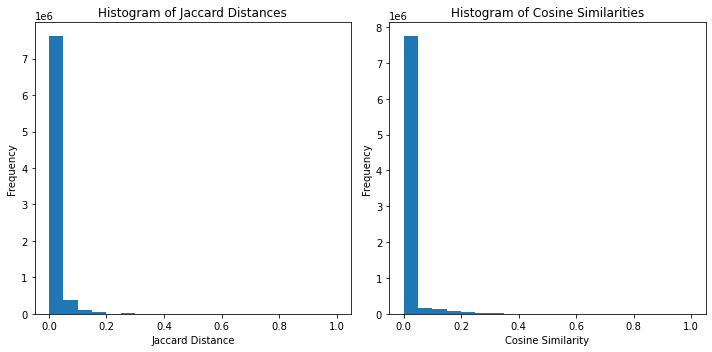

In [22]:
# Flatten the distance matrices and remove self-distances (i.e., distance of a tweet to itself)
jaccard_similarities_flat = jaccard_similarities[np.triu_indices(num_tweets, k=1)]
cosine_similarities_flat = cosine_similarity[np.triu_indices(num_tweets, k=1)]

# Plot the histograms
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(jaccard_similarities_flat, bins=20)
plt.xlabel('Jaccard Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Jaccard Distances')

plt.subplot(1, 2, 2)
plt.hist(cosine_similarities_flat, bins=20)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarities')

plt.tight_layout()
plt.show()

## DBSCAN Clustering with Jaccard Similarity

In [57]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_values = np.arange(0.2, 1.0, 0.05)  # Adjust the start, end, and step values as needed
min_samples_values = np.arange(5, 50, 2)  # Adjust the start, end, and step values as needed

best_eps = None
best_min_samples = None
best_score = -1
X = 1-jaccard_similarities

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        clusters = dbscan.fit_predict(1-jaccard_similarities)
        
        # Calculate silhouette score only for valid clusterings
        n_clusters = len(np.unique(clusters))
        if n_clusters > 10 and n_clusters < len(clusters):
            score = silhouette_score(X, clusters, metric='precomputed')
            cohesion = compute_cohesion(clusters, X)
            separation = compute_separation(clusters, X)
            if score > best_score:
                best_n_clusters = n_clusters
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                best_cohesion = cohesion
                best_seperation = separation

print(f"Best Silhouette Score: {best_score}")
print(f"Best eps value: {best_eps}")
print(f"Best min_samples value: {best_min_samples}")
print(f"Best n_clusters: {best_n_clusters}")
print(f"Best Cohesions: {best_cohesion}")
print(f"Best Seperation: {best_seperation}")

Best Silhouette Score: 0.000798137582731499
Best eps value: 0.7499999999999998
Best min_samples value: 15
Best n_clusters: 13
Best Cohesions: 11847509.406945456
Best Seperation: 3267.506236725273


In [24]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Set the parameters for DBSCAN clustering
eps = 0.7499999999999998
min_samples = 15

# Create a DBSCAN clustering instance with the Jaccard distance matrix
dbscan = DBSCAN(eps=eps, min_samples= min_samples, metric='precomputed')

# Fit the DBSCAN instance to the Jaccard distance matri
clusters = dbscan.fit_predict(1-jaccard_similarities)

n_clusters = len(np.unique(clusters))

# print(n_clusters)s)

In [25]:
cluster_labels = dbscan.labels_
cluster_labels
len(set(cluster_labels))

13

In [26]:
clusters = dbscan.fit_predict(1-jaccard_similarities)

In [27]:
from sklearn.manifold import TSNE

In [28]:
# Assuming 'word_freq_matrix' is already created
binary_matrix = (features > 0).astype(int)
dense_binary_matrix = binary_matrix.toarray()

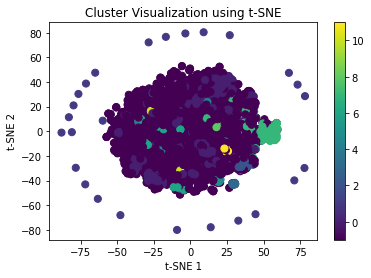

In [29]:
dense_binary_matrix = binary_matrix.toarray()

tsne = TSNE(n_components=2, metric='cosine', random_state=42, init='random')
reduced_data = tsne.fit_transform(dense_binary_matrix)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', marker='o', s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Cluster Visualization using t-SNE')
plt.colorbar()
plt.show()

In [30]:
terms = getMostCommonTerms(tweetVectorDataFrame, dbscan.labels_, 11);
print(terms) 

eating        6.211687
healthy       5.014397
hot           0.833258
ones          0.825133
superfoods    0.823394
smart         0.817838
facts         0.817838
living        0.793940
save          0.748206
learn         0.743783
Name: 11, dtype: float64


In [31]:
from sklearn.metrics import silhouette_score

score = silhouette_score(1-jaccard_similarities, clusters, metric='precomputed')
print("Silhouette Score:", score)

Silhouette Score: 0.000798137582731499


## K-Means Clustering with the Cosine Similarity Matrix

In [32]:
kmeans = KMeans()

In [33]:
inertia = []

for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, n_init=10, max_iter=300, random_state=0)
    kmeans.fit(cosine_similarity)
    inertia.append(kmeans.inertia_)

In [34]:
print(inertia)

[27488.729843772766, 26204.65340192139, 25048.399257741075, 24428.690726458386, 24042.648966209577, 23734.025338385385, 23513.94099783185, 23320.35539137118, 22820.189140758714, 22613.14377401053, 22399.284743074866, 22321.412079797523, 22315.937563645373, 22029.940848848077, 21811.43516521959, 21647.019938498, 21433.479842226836, 21269.377497949063, 21281.885362919267, 21184.72899663773, 20941.21246806891, 20874.86542039027, 20761.165787695292, 20695.598980326024, 20659.46820127953, 20453.443501795693, 20324.28659671435, 20269.632022560727, 20170.087352376817]


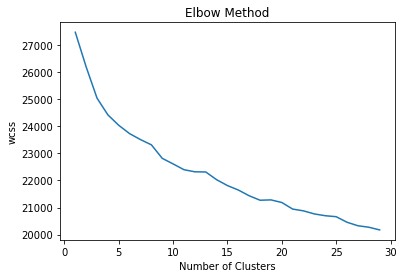

In [35]:
plt.plot(range(1,30), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

In [36]:
kmeans = KMeans(n_clusters=8, n_init=10, max_iter=300, random_state=0)
output = kmeans.fit_predict(cosine_similarity)
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(cluster_sizes)

[ 118   76  520 2649  120  231  170  161]


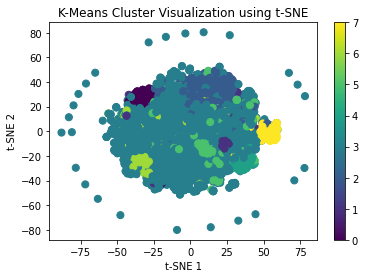

In [37]:
dense_binary_matrix = binary_matrix.toarray()

tsne = TSNE(n_components=2, metric='cosine', random_state=42, init='random')
reduced_data = tsne.fit_transform(dense_binary_matrix)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('K-Means Cluster Visualization using t-SNE')
plt.colorbar()
plt.show()

In [38]:
terms = getMostCommonTerms(tweetVectorDataFrame, kmeans.labels_, 4);

In [39]:
print(terms)

pounds            22.220645
weightloss        20.587460
lost              20.090318
getfit            13.795719
lbs               10.996503
transformation     6.959387
lose               5.950106
100                4.318177
weeklyweighin      4.252137
drops              3.817784
Name: 4, dtype: float64


# Test area

In [40]:
data = pd.read_csv(r"../inputdata/cnnhealth.txt", sep="|", header=None, on_bad_lines='skip')
data = pd.read_csv(r"../inputdata/cnnhealth.txt", sep="|", header=None, on_bad_lines='skip')
tweets = data[2].to_numpy()
print(tweets)

['An abundance of online info can turn us into e-hypochondriacs. Or, worse, lead us to neglect getting the care we need http://cnn.it/1L1t1Fv'
 'A plant-based diet that incorporates fish may be the key to preventing colorectal cancers: http://cnn.it/1xdpsjT http://pbs.twimg.com/media/CAARHEGWEAAJGz6.jpg'
 "It doesn't take much to damage your hearing at a sports bar or nightclub. That's why a billion people are at risk. http://cnn.it/1BOphBk"
 ...
 'Ann Romney talks about her experience with MS http://at.cnn.com/khb6keC'
 "Make sure your first marathon isn't your last! http://at.cnn.com/liehiPl"
 "Robin Roberts' cancer diagnosis http://at.cnn.com/XNq3fhk"]


In [42]:
X = 1-jaccard_similarities
cohesion = compute_cohesion(clusters, X)
separation = compute_separation(clusters, X)

In [43]:
print("Cohesion (SSE):", cohesion)
print("Separation (BSS):", separation)

Cohesion (SSE): 11847509.406945456
Separation (BSS): 3267.506236725273


# Spectral Clustering

In [58]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

In [59]:
cosine_similarity = 1-pairwise_distances(tweetVectors, metric="cosine")
cosine_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [60]:
n_clusters = 8
cosine_similarity = 1-pairwise_distances(tweetVectors, metric="cosine")
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')
spectral_clusters = spectral_clustering.fit_predict(1-cosine_similarity)

In [61]:
cohesion = compute_cohesion(clusters, 1-cosine_similarity)
separation = compute_separation(clusters, 1-cosine_similarity)
score = silhouette_score(1-cosine_similarity, clusters, metric='precomputed')

print("Silhouette Score:", score)
print("Cohesion (SSE):", cohesion)
print("Separation (BSS):", separation)

Silhouette Score: 0.008311659608199368
Cohesion (SSE): 29521819.80052432
Separation (BSS): 11.074793784271023


# Agglomerative Clustering

In [53]:
n_clusters = 12

agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='complete')
clusters = agg_clustering.fit_predict(1-cosine_similarity)

cohesion = compute_cohesion(clusters, 1-cosine_similarity)
separation = compute_separation(clusters, 1-cosine_similarity)
score = silhouette_score(1-cosine_similarity, clusters, metric='precomputed')

print("Silhouette Score:", score)
print("Cohesion (SSE):", cohesion)
print("Separation (BSS):", separation)

Cohesion (SSE): 17336983.646886315
Separation (BSS): 3751.977837943304


# Evaluating the Entropy and Purity

In [ ]:
#Looks like we need to select two of our clustering algos that produce the same amount of clusters because we do not have the true labels for the clusters
#So I selected the K-means clusters and the spectral clusters because they both have 8 clusters
# Then using the clusters from k-means and from spectral clustering we created a confusion matrix.

In [63]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(output, spectral_clusters)

cm

array([[ 115,    0,    0,    0,    0,    0,    1,    2],
       [  76,    0,    0,    0,    0,    0,    0,    0],
       [ 312,    0,    0,    0,    0,  193,    3,   12],
       [2388,    0,    1,   37,   16,    0,   47,  160],
       [  18,    0,  100,    0,    0,    0,    0,    2],
       [ 228,    0,    0,    0,    0,    0,    2,    1],
       [ 162,    0,    0,    0,    0,    0,    1,    7],
       [   5,  156,    0,    0,    0,    0,    0,    0]])

In [ ]:
# The purity is caluclated below

In [64]:
purity = np.sum(np.max(cm, axis=0)) / np.sum(cm)
print(f"Purity: {purity}")

Purity: 0.7656365883807169


In [66]:
# the entropy is the sum of - probablitiy * log2(probabilites)

In [65]:
def entropy(cluster_counts):
    cluster_size = np.sum(cluster_counts)
    probabilities = cluster_counts / cluster_size
    return -np.sum(probabilities * np.log2(probabilities + np.finfo(float).eps))

cluster_entropies = np.apply_along_axis(entropy, 1, cm)
weighted_entropies = (np.sum(cm, axis=1) / np.sum(cm)) * cluster_entropies
total_entropy = np.sum(weighted_entropies)

print(f"Entropy: {total_entropy}")

Entropy: 0.6053349266433427
